# KNN

Trying to train a supervised approach via k nearest neighbors

In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def load_and_prepare_data(features_path, labels_path, participant_info_path):
    """
    Load features, labels and participant info
    """
    # Load your data
    X = np.load(features_path)
    y = np.load(labels_path)
    
    # Load participant info from CSV
    participant_df = pd.read_csv(participant_info_path)
    participant_ids = participant_df['participant_id'].values
    
    return X, y, participant_ids

In [4]:
def stratified_participant_split(X, y, participant_ids, test_size=0.2, random_state=42):
    """
    Split data ensuring each participant is represented in both train and test sets,
    handling cases where a participant has too few samples of a class
    """
    X_train, X_test = [], []
    y_train, y_test = [], []
    
    # Split for each participant
    for participant in np.unique(participant_ids):
        mask = participant_ids == participant
        X_participant = X[mask]
        y_participant = y[mask]
        
        # Check class distribution for this participant
        unique_labels, counts = np.unique(y_participant, return_counts=True)
        
        # If any class has less than 2 samples, use regular split instead of stratified
        if any(counts < 2):
            print(f"Warning: Participant {participant} has too few samples for some classes.")
            print("Class distribution:", dict(zip(unique_labels, counts)))
            print("Using regular random split instead of stratified for this participant.\n")
            
            X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
                X_participant, 
                y_participant,
                test_size=test_size,
                random_state=random_state,
                stratify=None  # Don't stratify for this participant
            )
        else:
            # Use stratified split when we have enough samples
            X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
                X_participant, 
                y_participant,
                test_size=test_size,
                stratify=y_participant,
                random_state=random_state
            )
        
        X_train.append(X_train_p)
        X_test.append(X_test_p)
        y_train.append(y_train_p)
        y_test.append(y_test_p)
    
    # Combine all splits
    X_train = np.vstack(X_train)
    X_test = np.vstack(X_test)
    y_train = np.concatenate(y_train)
    y_test = np.concatenate(y_test)
    
    # Print overall class distribution
    print("\nOverall class distribution:")
    print("Training set:")
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    print(dict(zip(unique_train, counts_train)))
    print("\nTest set:")
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    print(dict(zip(unique_test, counts_test)))
    
    return X_train, X_test, y_train, y_test

In [5]:
def train_knn_with_cv(X, y, n_splits=5):
    """
    Train KNN with regular cross-validation (no participant awareness)
    """
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Initialize KNN
    knn = KNeighborsClassifier()
    
    # Create regular k-fold (no stratification needed)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Perform cross-validation
    cv_scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled)):
        # Train and evaluate on this fold
        knn.fit(X_scaled[train_idx], y[train_idx])
        score = knn.score(X_scaled[val_idx], y[val_idx])
        cv_scores.append(score)
        
        # Print fold statistics
        print(f"\nFold {fold + 1}:")
        val_labels = y[val_idx]
        for label in np.unique(y):
            l_count = np.sum(val_labels == label)
            print(f"Label {label}: {l_count} samples")
    
    cv_scores = np.array(cv_scores)
    print(f"\nCross-validation scores: {cv_scores}")
    print(f"Average CV score: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    return cv_scores

In [6]:
import os
def tune_hyperparameters(X_train, y_train):
    """
    Perform grid search with cross-validation and report detailed results
    """
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # Define parameter grid
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
    
    # Initialize KNN
    knn = KNeighborsClassifier()
    
    # Perform grid search
    grid_search = GridSearchCV(
        knn, 
        param_grid, 
        cv=5,
        scoring='accuracy', 
        n_jobs=-1,
        return_train_score=True  # This gives us more info
    )
    grid_search.fit(X_scaled, y_train)
    
    # Print detailed results
    print("\nCross-validation results:")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
    
    # Show CV scores for best parameters
    print("\nCV Scores for best parameters:")
    cv_scores = grid_search.cv_results_['split0_test_score'][grid_search.best_index_:grid_search.best_index_+1]
    for fold, score in enumerate(cv_scores):
        print(f"Fold {fold + 1}: {score:.3f}")
    
    return grid_search.best_params_

In [7]:
def evaluate_model(X_train, X_test, y_train, y_test, best_params, matrix_output_path):
    """
    Train final model with best parameters and evaluate
    """
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model with best parameters
    knn = KNeighborsClassifier(**best_params)
    knn.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = knn.predict(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nAccuracy: {accuracy:.3f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    # plt.show()
    os.makedirs("../../visualization/knn", exist_ok=True)
    plt.savefig(matrix_output_path, dpi=300, bbox_inches='tight')
    
    return knn, accuracy

### Standard MFCC Extraction

Class distribution: {'hhc': 16, 'kd': 17, 'sd': 1}
Using regular random split instead of stratified for this participant.

Class distribution: {'hhc': 1, 'kd': 9, 'sd': 6}
Using regular random split instead of stratified for this participant.


Overall class distribution:
Training set:
{'hhc': 1184, 'hho': 804, 'kd': 1423, 'sd': 1137}

Test set:
{'hhc': 314, 'hho': 205, 'kd': 353, 'sd': 294}

Tuning hyperparameters...

Cross-validation results:
Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best cross-validation score: 0.485

CV Scores for best parameters:
Fold 1: 0.478

Evaluating final model...

Accuracy: 0.843

Classification Report:
              precision    recall  f1-score   support

         hhc       0.83      0.81      0.82       314
         hho       0.91      0.87      0.89       205
          kd       0.80      0.91      0.85       353
          sd       0.88      0.78      0.83       294

    accuracy                           0.84    

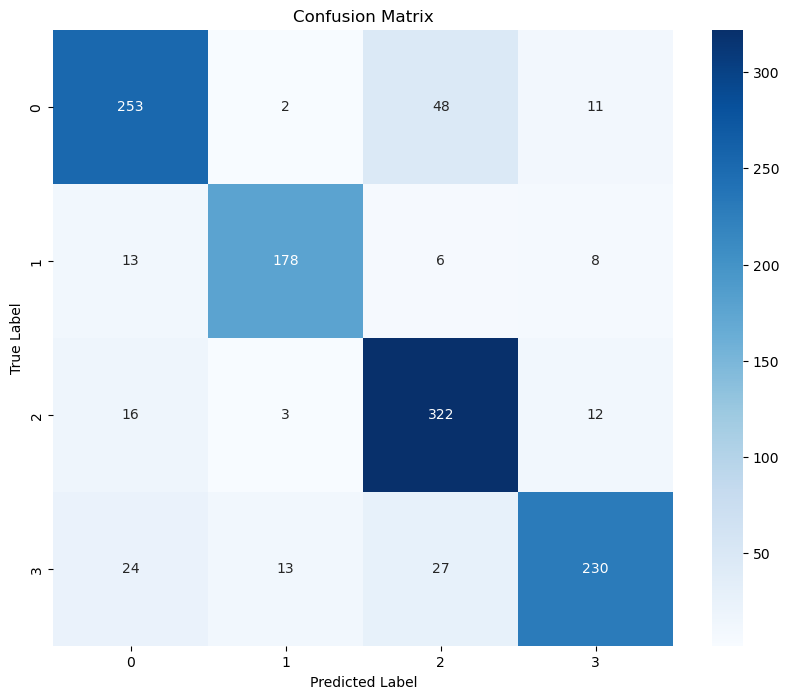

In [8]:
X_standard_mfcc, y_standard_mfcc, participant_ids_standard_mfcc = load_and_prepare_data(
    "../../extracted_features/features/mfcc_features.npy", 
    "../../extracted_features/labels/mfcc_labels.npy", 
    "../../segment_info/segment_info.csv"
)
    
# Split data into train and test sets - this maintains participant distribution
X_train_standard_mfcc, X_test_standard_mfcc, y_train_standard_mfcc, y_test_standard_mfcc = stratified_participant_split(
    X_standard_mfcc, y_standard_mfcc, participant_ids_standard_mfcc
)
    
# Tune hyperparameters using regular CV
print("\nTuning hyperparameters...")
best_params_mfcc = tune_hyperparameters(X_train_standard_mfcc, y_train_standard_mfcc)
    
# Evaluate final model on held-out test set
print("\nEvaluating final model...")
final_model, accuracy = evaluate_model(
    X_train_standard_mfcc, X_test_standard_mfcc, y_train_standard_mfcc, y_test_standard_mfcc, best_params_mfcc, "../../visualization/knn/mfcc.png"
)


Overall class distribution:
Training set:
{'hhc': 7177, 'hho': 4840, 'kd': 8525, 'sd': 6862}

Test set:
{'hhc': 1811, 'hho': 1214, 'kd': 2131, 'sd': 1724}

Tuning hyperparameters...

Cross-validation results:
Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best cross-validation score: 0.486

CV Scores for best parameters:
Fold 1: 0.465

Evaluating final model...

Accuracy: 0.922

Classification Report:
              precision    recall  f1-score   support

         hhc       0.92      0.90      0.91      1811
         hho       0.96      0.93      0.94      1214
          kd       0.89      0.94      0.92      2131
          sd       0.94      0.92      0.93      1724

    accuracy                           0.92      6880
   macro avg       0.93      0.92      0.92      6880
weighted avg       0.92      0.92      0.92      6880



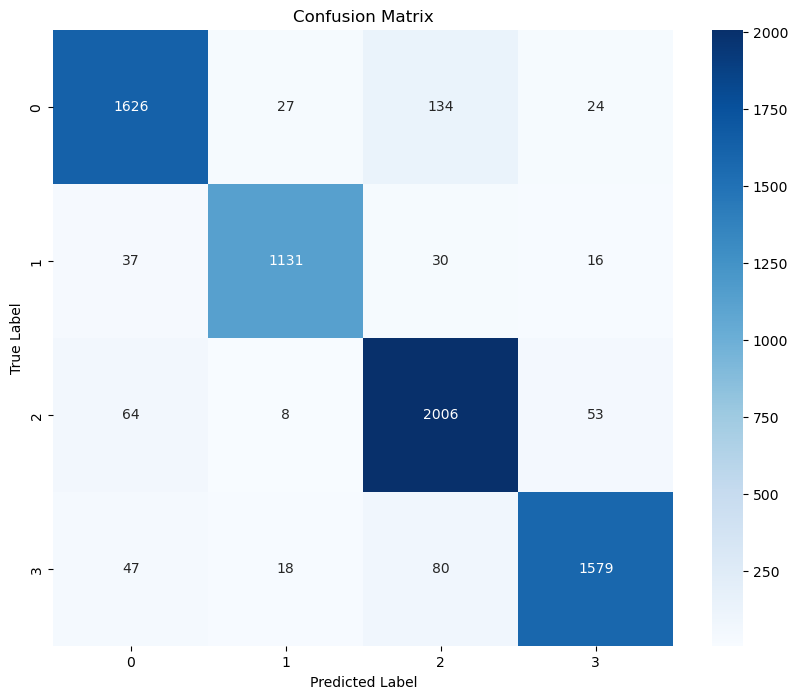

In [9]:
X_standard_mfcc_aug, y_standard_mfcc_aug, participant_ids_standard_mfcc_aug = load_and_prepare_data(
    "../../extracted_features/features/mfcc_features_aug.npy", 
    "../../extracted_features/labels/mfcc_labels_aug.npy", 
    "../../segment_info/augmented_segment_info.csv"
)
    
# Split data into train and test sets - this maintains participant distribution
X_train_standard_mfcc_aug, X_test_standard_mfcc_aug, y_train_standard_mfcc_aug, y_test_standard_mfcc_aug = stratified_participant_split(
    X_standard_mfcc_aug, y_standard_mfcc_aug, participant_ids_standard_mfcc_aug
)
    
# Tune hyperparameters using regular CV
print("\nTuning hyperparameters...")
best_params_mfcc_aug = tune_hyperparameters(X_train_standard_mfcc_aug, y_train_standard_mfcc_aug)
    
# Evaluate final model on held-out test set
print("\nEvaluating final model...")
final_model, accuracy = evaluate_model(
    X_train_standard_mfcc_aug, X_test_standard_mfcc_aug, y_train_standard_mfcc_aug, y_test_standard_mfcc_aug, best_params_mfcc_aug, "../../visualization/knn/mfcc_aug.png"
)

Class distribution: {'hhc': 16, 'kd': 17, 'sd': 1}
Using regular random split instead of stratified for this participant.

Class distribution: {'hhc': 1, 'kd': 9, 'sd': 6}
Using regular random split instead of stratified for this participant.


Overall class distribution:
Training set:
{'hhc': 1184, 'hho': 804, 'kd': 1423, 'sd': 1137}

Test set:
{'hhc': 314, 'hho': 205, 'kd': 353, 'sd': 294}

Tuning hyperparameters...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,


Cross-validation results:
Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best cross-validation score: 0.550

CV Scores for best parameters:
Fold 1: 0.551

Evaluating final model...

Accuracy: 0.899

Classification Report:
              precision    recall  f1-score   support

         hhc       0.84      0.89      0.87       314
         hho       0.92      0.90      0.91       205
          kd       0.91      0.97      0.94       353
          sd       0.95      0.82      0.88       294

    accuracy                           0.90      1166
   macro avg       0.90      0.90      0.90      1166
weighted avg       0.90      0.90      0.90      1166



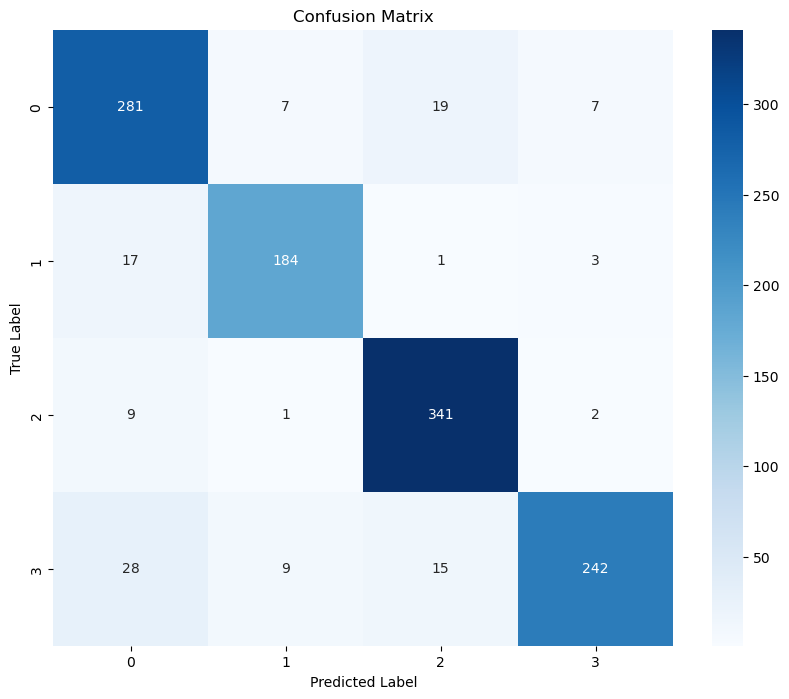

In [10]:
X_standard_mfcc_env, y_standard_mfcc_env, participant_ids_standard_mfcc_env = load_and_prepare_data(
    "../../extracted_features/features/mfcc_env_features.npy", 
    "../../extracted_features/labels/mfcc_env_labels.npy", 
    "../../segment_info/segment_info.csv"
)
    
# Split data into train and test sets - this maintains participant distribution
X_train_standard_mfcc_env, X_test_standard_mfcc_env, y_train_standard_mfcc_env, y_test_standard_mfcc_env = stratified_participant_split(
    X_standard_mfcc_env, y_standard_mfcc_env, participant_ids_standard_mfcc_env
)
    
# Tune hyperparameters using regular CV
print("\nTuning hyperparameters...")
best_params_mfcc_env = tune_hyperparameters(X_train_standard_mfcc_env, y_train_standard_mfcc_env)
    
# Evaluate final model on held-out test set
print("\nEvaluating final model...")
final_model, accuracy = evaluate_model(
    X_train_standard_mfcc_env, X_test_standard_mfcc_env, y_train_standard_mfcc_env, y_test_standard_mfcc_env, best_params_mfcc_env, "../../visualization/knn/mfcc_env.png"
)


Overall class distribution:
Training set:
{'hhc': 7177, 'hho': 4840, 'kd': 8525, 'sd': 6862}

Test set:
{'hhc': 1811, 'hho': 1214, 'kd': 2131, 'sd': 1724}

Tuning hyperparameters...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87,


Cross-validation results:
Best parameters: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'distance'}
Best cross-validation score: 0.557

CV Scores for best parameters:
Fold 1: 0.563

Evaluating final model...

Accuracy: 0.980

Classification Report:
              precision    recall  f1-score   support

         hhc       0.97      0.97      0.97      1811
         hho       0.98      0.98      0.98      1214
          kd       0.98      0.99      0.99      2131
          sd       0.99      0.98      0.98      1724

    accuracy                           0.98      6880
   macro avg       0.98      0.98      0.98      6880
weighted avg       0.98      0.98      0.98      6880



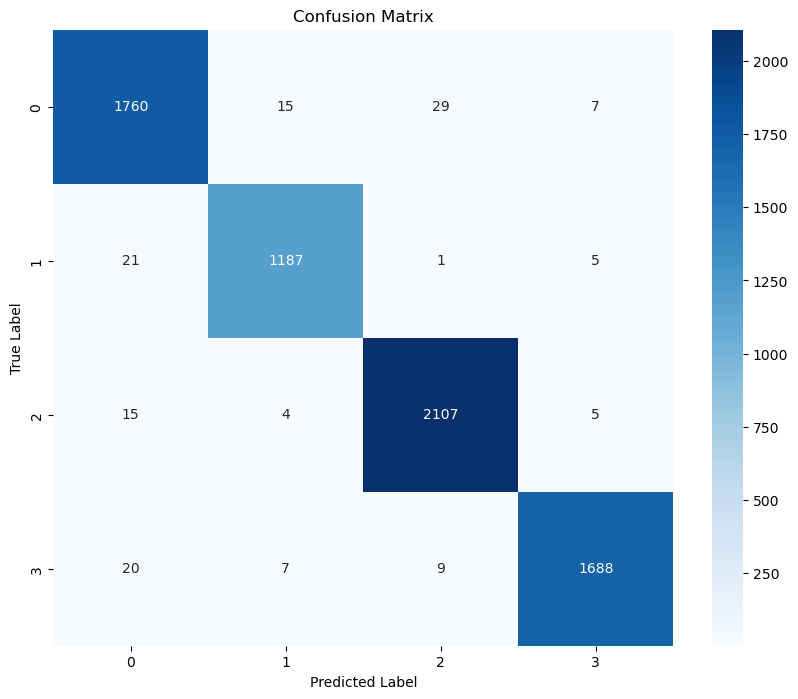

In [11]:
X_standard_mfcc_env_aug, y_standard_mfcc_env_aug, participant_ids_standard_mfcc_env_aug = load_and_prepare_data(
    "../../extracted_features/features/mfcc_env_aug_features.npy", 
    "../../extracted_features/labels/mfcc_env_aug_labels.npy", 
    "../../segment_info/augmented_segment_info.csv"
)
    
# Split data into train and test sets - this maintains participant distribution
X_train_standard_mfcc_env_aug, X_test_standard_mfcc_env_aug, y_train_standard_mfcc_env_aug, y_test_standard_mfcc_env_aug = stratified_participant_split(
    X_standard_mfcc_env_aug, y_standard_mfcc_env_aug, participant_ids_standard_mfcc_env_aug
)
    
# Tune hyperparameters using regular CV
print("\nTuning hyperparameters...")
best_params_mfcc_env_aug = tune_hyperparameters(X_train_standard_mfcc_env_aug, y_train_standard_mfcc_env_aug)
    
# Evaluate final model on held-out test set
print("\nEvaluating final model...")
final_model, accuracy = evaluate_model(
    X_train_standard_mfcc_env_aug, X_test_standard_mfcc_env_aug, y_train_standard_mfcc_env_aug, y_test_standard_mfcc_env_aug, best_params_mfcc_env_aug, "../../visualization/knn/mfcc_env_aug.png"
)

Class distribution: {'hhc': 16, 'kd': 17, 'sd': 1}
Using regular random split instead of stratified for this participant.

Class distribution: {'hhc': 1, 'kd': 9, 'sd': 6}
Using regular random split instead of stratified for this participant.


Overall class distribution:
Training set:
{'hhc': 1184, 'hho': 804, 'kd': 1423, 'sd': 1137}

Test set:
{'hhc': 314, 'hho': 205, 'kd': 353, 'sd': 294}

Tuning hyperparameters...

Cross-validation results:
Best parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Best cross-validation score: 0.556

CV Scores for best parameters:
Fold 1: 0.523

Evaluating final model...

Accuracy: 0.865

Classification Report:
              precision    recall  f1-score   support

         hhc       0.82      0.85      0.83       314
         hho       0.91      0.86      0.88       205
          kd       0.87      0.92      0.90       353
          sd       0.89      0.82      0.85       294

    accuracy                           0.87     

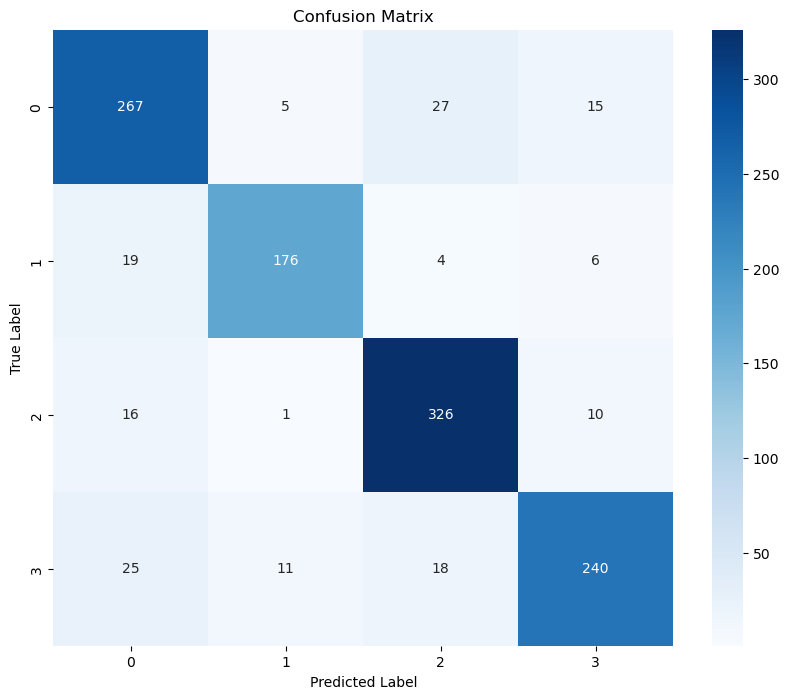

In [12]:
X_standard_mfcc_extracted, y_standard_mfcc_extracted, participant_ids_standard_mfcc_extracted = load_and_prepare_data(
    "../../extracted_features/features/mfcc_extracted_features.npy", 
    "../../extracted_features/labels/mfcc_extracted_labels.npy", 
    "../../segment_info/segment_info.csv"
)
    
# Split data into train and test sets - this maintains participant distribution
X_train_standard_mfcc_extracted, X_test_standard_mfcc_extracted, y_train_standard_mfcc_extracted, y_test_standard_mfcc_extracted = stratified_participant_split(
    X_standard_mfcc_extracted, y_standard_mfcc_extracted, participant_ids_standard_mfcc_extracted
)
    
# Tune hyperparameters using regular CV
print("\nTuning hyperparameters...")
best_params_mfcc_extracted = tune_hyperparameters(X_train_standard_mfcc_extracted, y_train_standard_mfcc_extracted)
    
# Evaluate final model on held-out test set
print("\nEvaluating final model...")
final_model, accuracy = evaluate_model(
    X_train_standard_mfcc_extracted, X_test_standard_mfcc_extracted, y_train_standard_mfcc_extracted, y_test_standard_mfcc_extracted, best_params_mfcc_extracted, "../../visualization/knn/mfcc_extracted.png"
)